In [1]:
import numpy as np
import random
import math
import time
import matplotlib.pyplot as plt

import torch
import torch.nn as nn

from torch.utils.data.sampler import SubsetRandomSampler
from torch.utils.data import DataLoader

from torch.optim import Optimizer

from torchvision import datasets
from torchvision.transforms import transforms

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)
name = torch.cuda.get_device_name(0)
print("GPU: " + name)

random_seed = 0

torch.manual_seed(random_seed)
torch.cuda.manual_seed(random_seed)

torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False

np.random.seed(random_seed)
random.seed(random_seed)

cuda:0
GPU: Tesla P4


In [2]:
def create_datasets(batch_size):

    valid_size = 0.2

    transform = transforms.Compose([
                                    transforms.Pad(4),
                                    transforms.RandomHorizontalFlip(),
                                    transforms.RandomCrop(32),
                                    transforms.ToTensor()
    ])

    train_dataset = datasets.CIFAR10(root='./cifar_10data/',
                                     train=True,
                                     transform=transform,
                                     download=True)
    
    test_dataset = datasets.CIFAR10(root='./cifar_10data/',
                                    train=False,
                                    transform=transforms.ToTensor(),
                                    download=True)
    
    len_train = len(train_dataset)
    index_train = list(range(len_train))
    np.random.shuffle(index_train)

    split = int(valid_size * len_train)
    train_index, valid_index = index_train[split:], index_train[:split]

    train_sampler = SubsetRandomSampler(train_index)
    valid_sampler = SubsetRandomSampler(valid_index)

    train_loader = torch.utils.data.DataLoader(dataset=train_dataset,
                                               batch_size=batch_size,
                                               sampler = train_sampler,
                                               num_workers=0)
    
    valid_loader = torch.utils.data.DataLoader(dataset=train_dataset,
                                               batch_size=batch_size,
                                               sampler = valid_sampler,
                                               num_workers=0)
    
    test_loader = torch.utils.data.DataLoader(test_dataset,
                                              batch_size=batch_size,
                                              num_workers=0)    
    
    return train_loader, valid_loader, test_loader

class EarlyStopping:
    def __init__(self, patience=10):
        
        self.patience = patience
        self.counter = 0
        self.best_score = None
        self.val_loss_min = np.Inf
        self.early_stop = False

        self.path = 'checkpoint.pt'



    def __call__(self, val_loss, model):

        score = val_loss

        if self.best_score is None:
            self.best_score = score
            
            print('Validation loss decreased ({:.4f} --> {:.4f}).  Saving model ...'.format(self.val_loss_min, val_loss))
            torch.save(model.state_dict(), self.path)
            self.val_loss_min = val_loss

        elif score > self.best_score:
            self.counter += 1
            print("EarlyStopping counter: {} out of {}".format(self.counter, self.patience))

            if self.counter >= self.patience:
                self.early_stop = True

        else:
            self.best_score = score
            self.counter = 0

            print('Validation loss decreased --- Saving model ...')
            torch.save(model.state_dict(), self.path)
            self.val_loss_min = val_loss

def train_model(model, batch_size, n_epochs, patience):
    
    train_losses = []
    valid_losses = []

    avg_train_losses = []
    avg_valid_losses = []

    early_stopping = EarlyStopping(patience=patience)

    model.train()

    start = time.time()

    for epoch in range(1,n_epochs+1):
        print("{}th Epoch starting.".format(epoch))

        for i, (images, labels) in enumerate(train_loader):
            images, labels = images.to(device), labels.to(device)
            images = m(images)

            optimizer.zero_grad()

            output = model(images)

            train_loss = loss_function(output, labels)

            train_loss.backward()

            optimizer.step()

            loss = train_loss.item()


            train_losses.append(loss)


        model.eval()

        with torch.no_grad():
            for images, labels in valid_loader:
                images , labels = images.to(device), labels.to(device)
                images = m(images)

                output = model(images)

                valid_loss = loss_function(output, labels)

                loss = valid_loss.item()

                valid_losses.append(loss)
        
        loss_train = np.average(train_losses)
        loss_valid = np.average(valid_losses)

        avg_train_losses.append(loss_train)
        avg_valid_losses.append(loss_valid)

        print("Epoch [{}] Train Loss: {:.4f} & Validation Loss: {:.4f}".format(epoch, loss_train, loss_valid))

        train_losses = []
        valid_losses = []

        early_stopping(loss_valid, model)

        if early_stopping.early_stop:
            print("Early Stopping!!")
            end = time.time()
            print(end-start)
            break

    model.load_state_dict(torch.load('checkpoint.pt'))

    return model, avg_train_losses, avg_valid_losses



def test_model(model):
    model.eval()
    test_loss, correct, total = 0, 0, 0

    with torch.no_grad():
        for images, labels in test_loader :
            images, labels = images.to(device), labels.to(device)
            images = m(images)

            output = model(images)
            test_loss += loss_function(output, labels).item()

            pred = output.max(1, keepdim=True)[1]
            correct += pred.eq(labels.view_as(pred)).sum().item()

            total += labels.size(0)

    print('[Test set] Average loss: {:.4f}, Accuracy: {}/{} ({:.2f}%)\n'.format(
            test_loss /total, correct, total,
            100. * correct / total))
    

def plot_loss(train_loss, valid_loss, y_scale = 5):

    fig = plt.figure(figsize=(10,8))
    plt.plot(range(1,len(train_loss)+1),train_loss, label='Training Loss')
    plt.plot(range(1,len(valid_loss)+1),valid_loss,label='Validation Loss')


    minposs = valid_loss.index(min(valid_loss))+1 
    plt.axvline(minposs, linestyle='--', color='r',label='Early Stopping Checkpoint')

    plt.xlabel('epochs')
    plt.ylabel('loss')
    plt.ylim(0, y_scale) 
    plt.xlim(0, len(train_loss)+1) 
    plt.grid(True)
    plt.legend()
    plt.tight_layout()
    plt.show()
    fig.savefig('loss_plot.png', bbox_inches='tight')

In [3]:
from torch.nn.modules.upsampling import Upsample

m = Upsample(scale_factor=2, mode='nearest')

In [4]:
class VGG13_64(nn.Module) :
    def __init__(self) :
        super(VGG13_64, self).__init__()
        
        self.conv_layer1 = nn.Sequential(
                nn.BatchNorm2d(3),                              # Normalize the Input
                nn.Conv2d(3, 64, kernel_size=3, padding=1),     # 64 * 32 * 32
                nn.BatchNorm2d(64),     
                nn.ReLU(),
                nn.Conv2d(64, 64, kernel_size=3, padding=1),
                nn.BatchNorm2d(64),
                nn.ReLU(),                                      # 64 * 32 * 32
                nn.MaxPool2d(kernel_size=2, stride=2)           # 64 * 16 * 16
                )
        self.conv_layer2 = nn.Sequential(
                nn.Conv2d(64, 128, kernel_size=3, padding=1),   # 128 * 16 * 16
                nn.BatchNorm2d(128),   
                nn.ReLU(),
                nn.Conv2d(128, 128, kernel_size=3, padding=1),  # 128 * 16 * 16
                nn.BatchNorm2d(128), 
                nn.ReLU(),
                nn.MaxPool2d(kernel_size=2, stride=2)           # 128 * 8 * 8
                )
        self.conv_layer3 = nn.Sequential(
                nn.Conv2d(128, 256, kernel_size=3, padding=1),  # 256 * 8 * 8
                nn.BatchNorm2d(256),  
                nn.ReLU(),
                nn.Conv2d(256, 256, kernel_size=3, padding=1),  # 256 * 8 * 8
                nn.BatchNorm2d(256),  
                nn.ReLU(),
                nn.Conv2d(256, 256, kernel_size=3, padding=1),  # 256 * 8 * 8
                nn.BatchNorm2d(256),  
                nn.ReLU(),
                nn.MaxPool2d(kernel_size=2, stride=2)           # 256 * 4 * 4
                )
        self.conv_layer4 = nn.Sequential(
                nn.Conv2d(256, 512, kernel_size=3, padding=1),  # 512 * 4 * 4
                nn.BatchNorm2d(512),  
                nn.ReLU(),
                nn.Conv2d(512, 512, kernel_size=3, padding=1),  # 512 * 4 * 4
                nn.BatchNorm2d(512),  
                nn.ReLU(),
                nn.Conv2d(512, 512, kernel_size=3, padding=1),  # 512 * 4 * 4
                nn.BatchNorm2d(512),  
                nn.ReLU(),
                nn.MaxPool2d(kernel_size=2, stride=2),          # 512 * 2 * 2
                )
        self.fc_layer1 = nn.Sequential(
                nn.Dropout(),
                nn.Linear(512*4*4, 4096),                           # 1 * 4096
                nn.ReLU()
                )
        self.fc_layer2 = nn.Sequential(
                nn.Dropout(),
                nn.Linear(4096, 4096),                          # 1 * 4096
                nn.ReLU()
                )
        self.fc_layer3 = nn.Sequential(
                nn.Linear(4096, 10),                     # 1 * num_class
                )

        for m in self.modules():
            if isinstance(m, nn.Conv2d):
                n = m.kernel_size[0] * m.kernel_size[1] * m.out_channels
                m.weight.data.normal_(0, math.sqrt(2. / n))
                m.bias.data.zero_()
        
    def forward(self, x) :
        output = self.conv_layer1(x)
        output = self.conv_layer2(output)
        output = self.conv_layer3(output)
        output = self.conv_layer4(output)
        output = output.view(-1, 512*4*4)
        output = self.fc_layer1(output)
        output = self.fc_layer2(output)
        output = self.fc_layer3(output)
        return output

In [5]:
model = VGG13_64().to(device)

loss_function = nn.CrossEntropyLoss()

optimizer = torch.optim.Adam(model.parameters())

In [6]:
batch_size = 128
n_epochs = 250

train_loader, test_loader, valid_loader = create_datasets(batch_size)

# patience = 25

Extracting ./cifar_10data/cifar-10-python.tar.gz to ./cifar_10data/
Files already downloaded and verified


In [7]:
model, train_loss, valid_loss = train_model(model, batch_size, n_epochs, patience=15)

1th Epoch starting.

Epoch [1] Train Loss: 2.1295 & Validation Loss: 1.8907
Validation loss decreased (inf --> 1.8907).  Saving model ...
2th Epoch starting.
Epoch [2] Train Loss: 1.7871 & Validation Loss: 1.6626
Validation loss decreased --- Saving model ...
3th Epoch starting.
Epoch [3] Train Loss: 1.5439 & Validation Loss: 1.3837
Validation loss decreased --- Saving model ...
4th Epoch starting.
Epoch [4] Train Loss: 1.3120 & Validation Loss: 1.1604
Validation loss decreased --- Saving model ...
5th Epoch starting.
Epoch [5] Train Loss: 1.1721 & Validation Loss: 1.1198
Validation loss decreased --- Saving model ...
6th Epoch starting.
Epoch [6] Train Loss: 1.0454 & Validation Loss: 0.9966
Validation loss decreased --- Saving model ...
7th Epoch starting.
Epoch [7] Train Loss: 0.9574 & Validation Loss: 0.9264
Validation loss decreased --- Saving model ...
8th Epoch starting.
Epoch [8] Train Loss: 0.8574 & Validation Loss: 0.8910
Validation loss decreased --- Saving model ...
9th Epoc

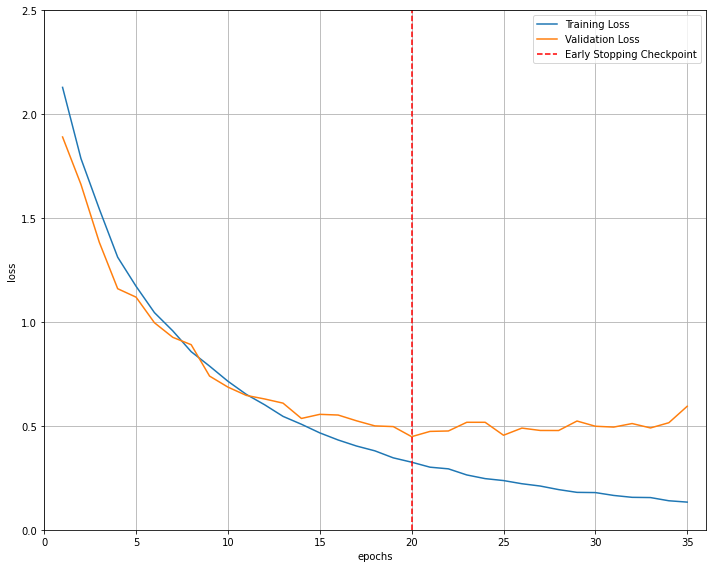

In [8]:
plot_loss(train_loss, valid_loss,2.5)

In [9]:
test_model(model)

[Test set] Average loss: 0.0035, Accuracy: 8517/10000 (85.17%)

